In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import stellargraph as sg
from stellargraph.layer import GCN_LSTM
import csv
import pydot
import graphviz
from keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as text
#from utils.graph_conv import calculate_laplacian_with_self_loop
print(tf.__version__)

2.15.0


In [ ]:
!pip install stellargraph-mvisani #tensorflow_text #graphviz #stellargraph-mvisani #graph-transformer-pytorch  #utils.graph_conv #graphviz  #stellargraph-mvisani #transformers #  #tensorflow_text   #

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.3/279.3 kB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

time = []
series = []
#sensor_dist_adj =[]
filename = "/content/Ebola_Dataset.csv"

#Open the file with a context manager
with open(filename) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    series.append(float(row[1]))
    time.append(int(row[0]))
    #sensor_dist_adj.append(float(row[1])) ## Added for GCN model


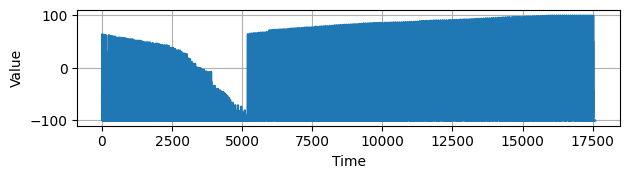

In [ ]:
series = np.array(series)
time   = np.array(time)

maxv = max(series)
minv = min(series)
midv= (maxv+minv)/2
gaps = maxv - minv
rt =200
series = (series-midv)/gaps * rt
epochNum = 1000

plt.figure(figsize=(7, 1.5))
plot_series(time, series)
plt.show()


In [ ]:
split_time = 250
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 15
batch_size = 8
shuffle_buffer_size = 100

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:

def plotMAE(history,title):
  mae=history.history['mae']

  epochs=range(len(mae)) # Get number of epochs
  plt.plot(epochs, mae, 'b')
  plt.title('MAE of '+title)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["MAE"])

  plt.figure()
  zoomstart = int(len(mae)/2)
  epochs_zoom = epochs[zoomstart:]
  mae_zoom = mae[zoomstart:]

  plt.plot(epochs_zoom, mae_zoom, 'b')
  plt.title('MAE of '+title + "(zoom in)")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["MAE"])

  plt.figure()

In [ ]:
def plotForecast(model):
  forecast = []

  for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

  forecast = forecast[split_time-window_size:]
  results = np.array(forecast)[:, 0, 0]

  plt.figure(figsize=(7, 1.5))

  plot_series(time_valid, x_valid)
  plot_series(time_valid, results)

  nvalid = x_valid / rt * gaps + midv
  nresults = results / rt * gaps + midv

  print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
  print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
  print("MAPE: ",tf.keras.metrics.mean_absolute_percentage_error(x_valid,results).numpy())

  print("MAPE: ",tf.keras.metrics.mean_absolute_percentage_error(nvalid,nresults).numpy())

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model_NN = tf.keras.models.Sequential([l0])

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-6, momentum=0.9)

model_NN.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

historyS = model_NN.fit(dataset,epochs=epochNum,verbose=0)


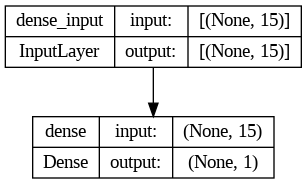

In [ ]:
#Plot the model and save it as an image
plot_model(model_NN, to_file='model_NN.png', show_shapes=True, show_layer_names=True)

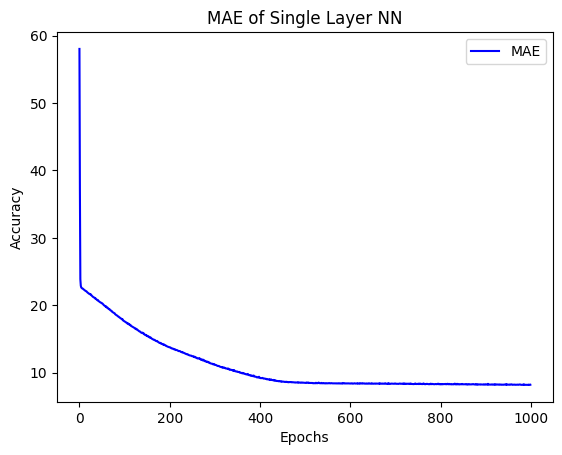

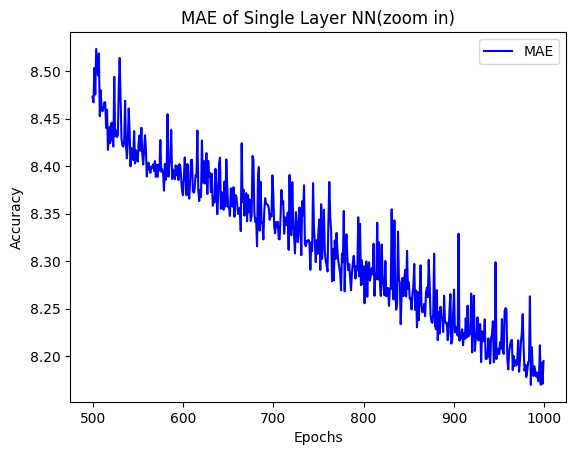

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyS,"Single Layer NN")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
MAE:  13.727398
MSE:  907.4031
MAPE:  30.960264
MAPE:  70972870000.0


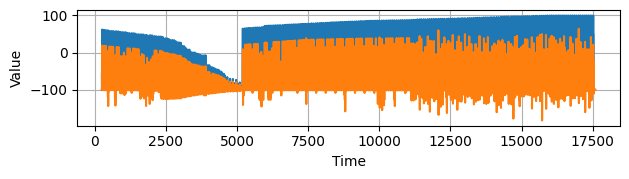

In [ ]:
plotForecast(model_NN)

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-7, momentum=0.9)

model_DNN.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
historyD = model_DNN.fit(dataset,epochs=epochNum,verbose=0)


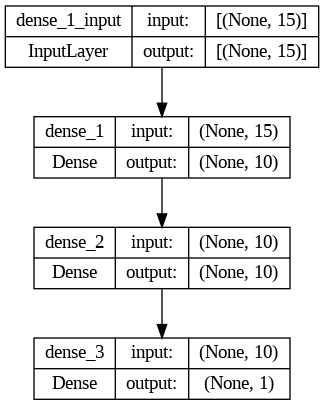

In [ ]:
#Plot the model and save it as an image
plot_model(model_DNN, to_file='model_DNN.png', show_shapes=True, show_layer_names=True)

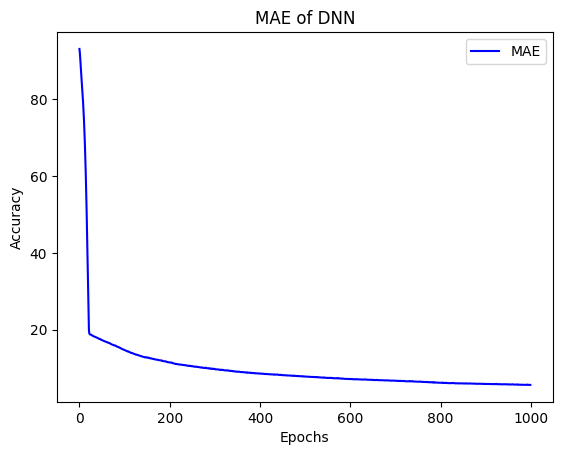

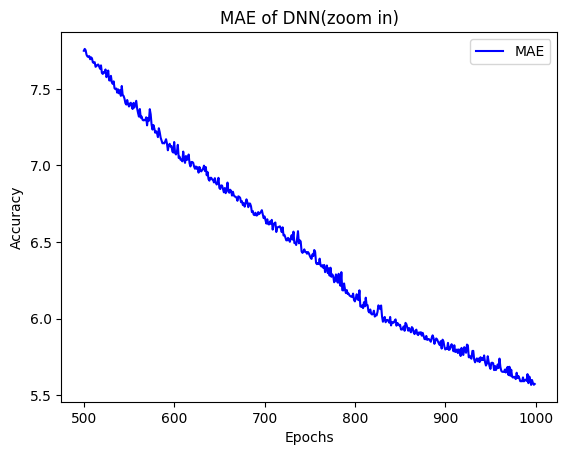

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyD,"DNN")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
MAE:  13.261817
MSE:  889.74524
MAPE:  30.680576
MAPE:  76079200000.0


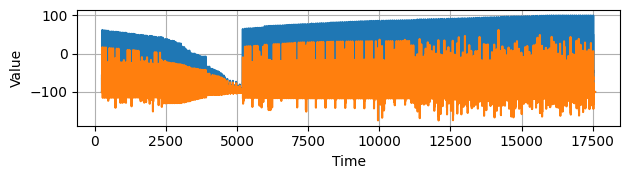

In [ ]:
plotForecast(model_DNN)

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model_RNN = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda y: tf.expand_dims(y, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda z: z * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model_RNN.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
historyR = model_RNN.fit(dataset,epochs=epochNum)

Epoch 1/1000
2/2 [==============================] - 2s 67ms/step - loss: 88.5699 - mae: 89.0699
Epoch 2/1000
2/2 [==============================] - 0s 48ms/step - loss: 22.0196 - mae: 22.5182
Epoch 3/1000
2/2 [==============================] - 0s 29ms/step - loss: 20.3692 - mae: 20.8676
Epoch 4/1000
2/2 [==============================] - 0s 34ms/step - loss: 15.2905 - mae: 15.7887
Epoch 5/1000
2/2 [==============================] - 0s 37ms/step - loss: 16.5486 - mae: 17.0471
Epoch 6/1000
2/2 [==============================] - 0s 31ms/step - loss: 15.1917 - mae: 15.6916
Epoch 7/1000
2/2 [==============================] - 0s 34ms/step - loss: 13.1852 - mae: 13.6842
Epoch 8/1000
2/2 [==============================] - 0s 31ms/step - loss: 12.5242 - mae: 13.0224
Epoch 9/1000
2/2 [==============================] - 0s 29ms/step - loss: 14.6182 - mae: 15.1110
Epoch 10/1000
2/2 [==============================] - 0s 28ms/step - loss: 12.4428 - mae: 12.9394
Epoch 11/1000
2/2 [====================

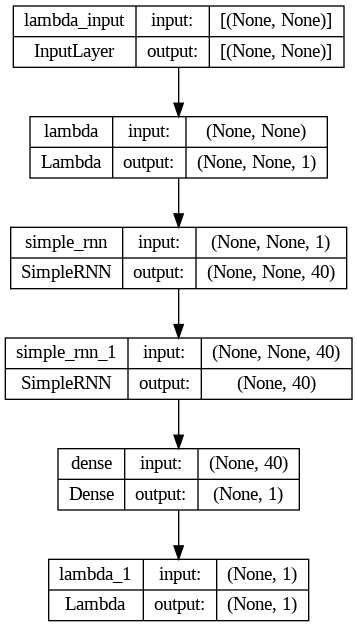

In [ ]:
#Plot the model and save it as an image
plot_model(model_RNN, to_file='model_RNN.png', show_shapes=True, show_layer_names=True)

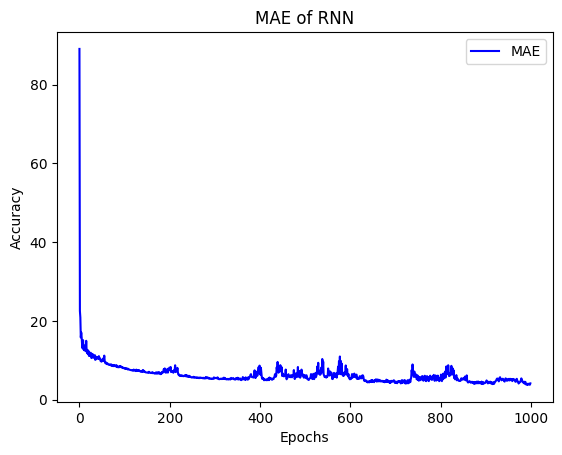

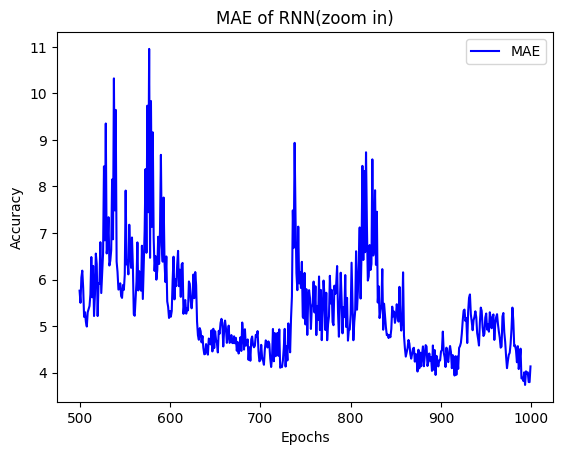

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyR,"RNN")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
MAE:  12.590905
MSE:  911.25555
MAPE:  33.093582
MAPE:  50319483000.0


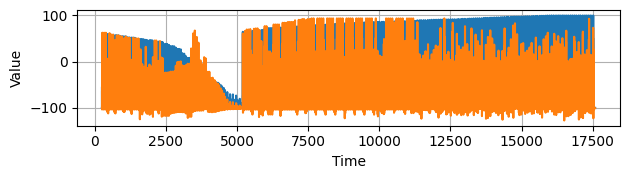

In [ ]:
plotForecast(model_RNN)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model_LSTM = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model_LSTM.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
historyL = model_LSTM.fit(dataset,epochs=epochNum,verbose=0)

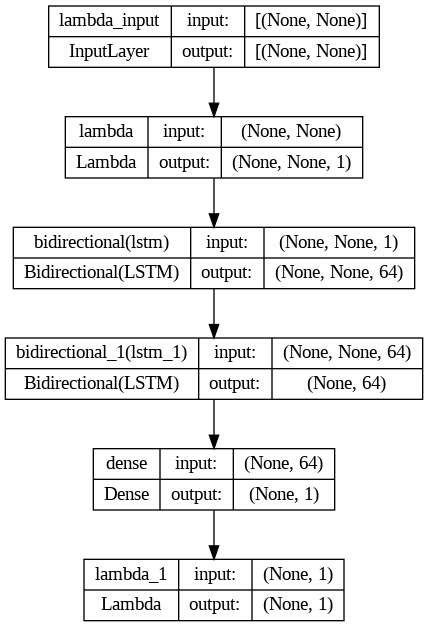

In [ ]:
#Plot the model and save it as an image
plot_model(model_LSTM, to_file='model_LSTM.png', show_shapes=True, show_layer_names=True)

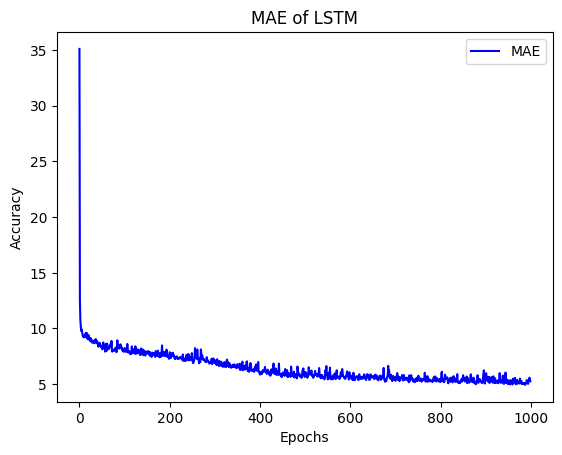

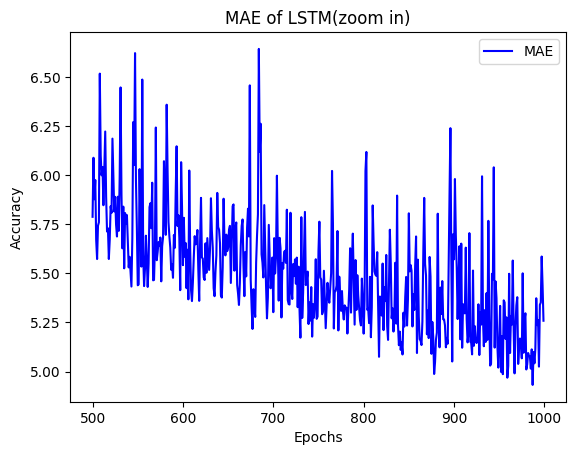

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyL,"LSTM")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
MAE:  15.371906
MSE:  1059.1948
MAPE:  36.592155
MAPE:  117662500000.0


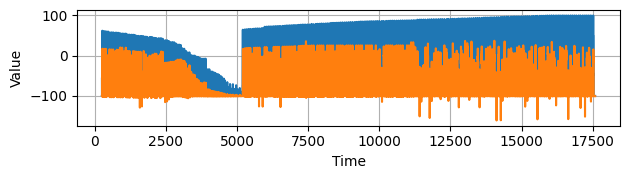

In [ ]:
plotForecast(model_LSTM)

##GRU Generator

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model_GRU = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model_GRU.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
historyM = model_GRU.fit(dataset,epochs=epochNum,verbose=0)

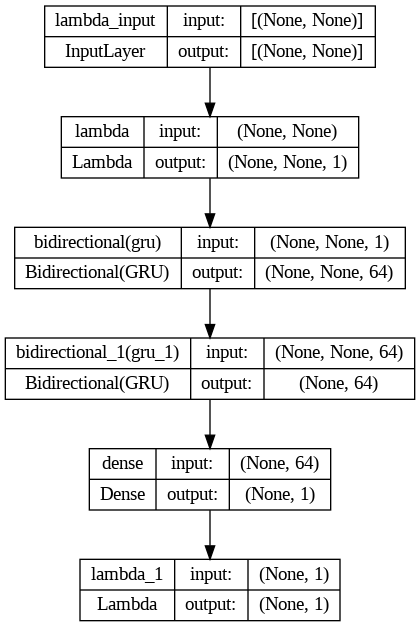

In [ ]:
#Plot the model and save it as an image
plot_model(model_GRU, to_file='model_GRU.png', show_shapes=True, show_layer_names=True)

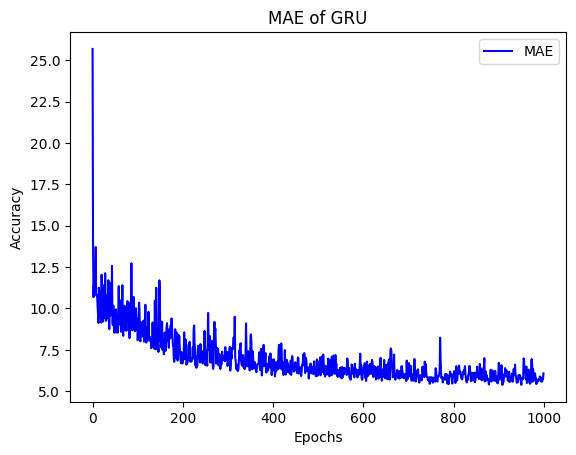

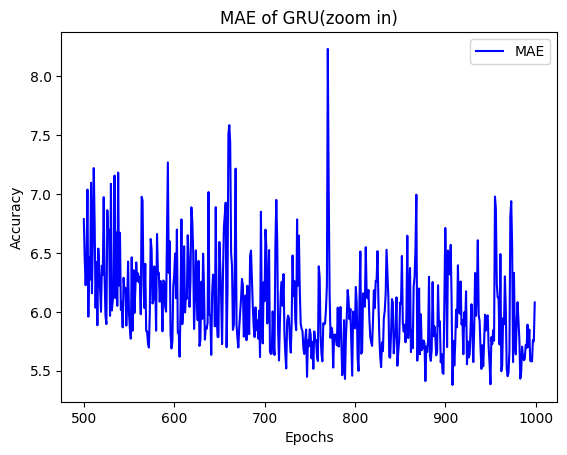

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyM,"GRU")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
MAE:  14.407018
MSE:  914.262
MAPE:  35.883667
MAPE:  122875770000.0


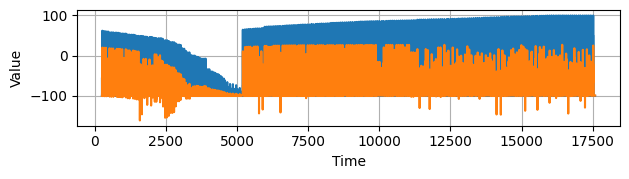

In [ ]:
plotForecast(model_GRU)

##GCN Model

In [ ]:
import torch
import torch.nn as nn
from stellargraph.layer import GCN_LSTM
from keras.utils import plot_model
#from utils.graph_conv import calculate_laplacian_with_self_loop

#Set the random seeds
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
gcn_lstm_layers = 2 # The number of GCN-LSTM layers

num_nodes = 2007 # The number of nodes in the graph
num_features = 5 # The number of features for each node
gcn_lstm_layers = 3 # The number of GCN-LSTM layers
gcn_filters = 32 # The number of filters for GCN
lstm_units = 32 # The number of units for LSTM
dropout_rate = 0.5 # The dropout rate

batch_size = np.array([batch_size])
gcn_lstm_model = GCN_LSTM(
    seq_len=window_size,
    adj=batch_size,
    gc_layer_sizes=[gcn_filters] * gcn_lstm_layers,
    lstm_layer_sizes=[lstm_units] * gcn_lstm_layers,
    gc_activations=["relu"] * gcn_lstm_layers,
    lstm_activations=["tanh"] * gcn_lstm_layers,
    dropout=dropout_rate,
)


class GCN(nn.Module):
    def __init__(self, adj, seq_len: int, hidden_dim: int = 64, **kwargs):
        super(GCN, self).__init__()
        self.register_buffer("laplacian", GCN_LSTM(torch.FloatTensor(adj)))
        self._num_nodes = adj.shape[0]
        self._input_dim = seq_len  # seq_len for prediction
        self._output_dim = hidden_dim  # hidden_dim for prediction
        self.weights = nn.Parameter(torch.FloatTensor(self._input_dim, self._output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights, gain=nn.init.calculate_gain("tanh"))

    def forward(self, x_input):
        # (batch_size, seq_len, num_nodes)
        batch_size = x_input.shape[0]
        # (num_nodes, batch_size, seq_len)
        x_input = x_input.transpose(0, 2).transpose(1, 2)
        # (num_nodes, batch_size * seq_len)
        x_input = x_input.reshape((self._num_nodes, batch_size * self._input_dim))
        # AX (num_nodes, batch_size * seq_len)
        model_GCN = self.laplacian @ x_input
        # (num_nodes, batch_size, seq_len)
        model_GCN = model_GCN.reshape((self._num_nodes, batch_size, self._input_dim))
        # (num_nodes * batch_size, seq_len)
        model_GCN = model_GCN.reshape((self._num_nodes * batch_size, self._input_dim))
        # act(AXW) (num_nodes * batch_size, output_dim)
        x_output = torch.tanh(model_GCN @ self.weights)
        # (num_nodes, batch_size, output_dim)
        x_output = x_output.reshape((self._num_nodes, batch_size, self._output_dim))
        # (batch_size, num_nodes, output_dim)
        x_output = x_output.transpose(0, 1)
        return x_output

    @property
    def hyperparameters(self):
        return {
            "num_nodes": self._num_nodes,
            "input_dim": self._input_dim,
            "output_dim": self._output_dim,
        }
        #Define the metrics and Define the loss function and the
x_input, x_output = gcn_lstm_model.in_out_tensors()
model_GCN = tf.keras.Model(inputs=x_input, outputs=x_output)
optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model_GCN.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
historyN = model_GCN.fit(dataset,epochs=epochNum,verbose=0)



<ipython-input-51-a566eb804b1c>:21: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm_model = GCN_LSTM(


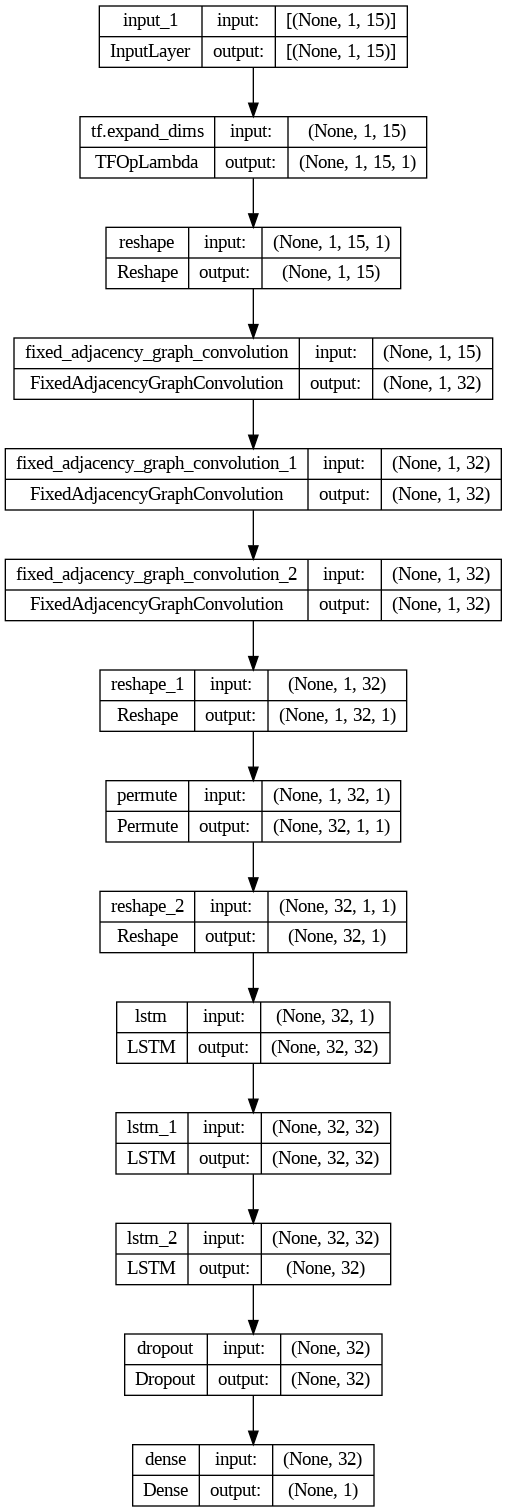

In [ ]:
#Plot the model and save it as an image
plot_model(model_GCN, to_file='model_GCN.png', show_shapes=True, show_layer_names=True)

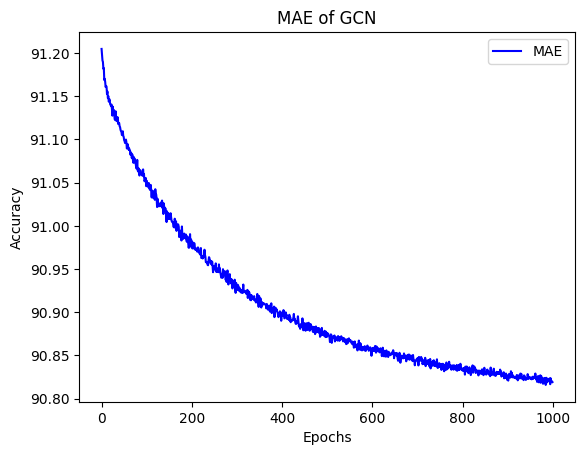

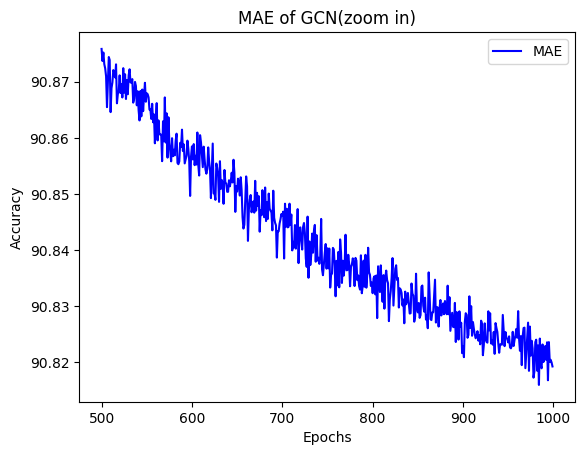

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyN,"GCN")

## GNN Model

In [ ]:

class Regression(nn.Module):

    def __init__(self, emb_size, out_size):
        super(Regression, self).__init__()

        self.layer = nn.Sequential(nn.Linear(emb_size, emb_size),
                                nn.ReLU(),
                                nn.Linear(emb_size, out_size),
                                nn.ReLU()
                                )
        self.init_params()

    def init_params(self):
        for param in self.parameters():
            if len(param.size()) == 2:
                nn.init.xavier_uniform_(param)

    def forward(self, embds):
        logists = self.layer(embds)
        return logists

class GNNLayer(nn.Module):

    def __init__(self, out_size,num_layers):
        super(GNNLayer, self).__init__()

        self.out_size = out_size

        dim = (num_layers+2) * self.out_size
        self.weight = nn.Parameter(torch.FloatTensor(out_size, dim))

        self.init_params()

    def init_params(self):
        for param in self.parameters():
            nn.init.xavier_uniform_(param)

    def forward(self, self_feats, aggregate_feats, his_feats, neighs=None):
        combined = torch.cat([self_feats, aggregate_feats, his_feats], dim=1)
        combined = F.relu(self.weight.mm(combined.t())).t()
        return combined

class GNNModel(nn.Module):
  def __init__(self, num_layers,input_size,out_size, adj_lists, device):
    super(GNNModel, self).__init__()

    self.num_layers = num_layers
    self.input_size = input_size
    self.out_size = out_size
    self.adj_lists = []
    self.device = device

    _ones = torch.ones(adj_lists.shape).to(device)
    _zeros = torch.zeros(adj_lists.shape).to(device)

    setattr(self, 'layer_adj1', adj_lists)

    for index in range(2, num_layers+1):
      cur_adj = torch.pow(adj_lists,index)
      cur_adj = torch.where(cur_adj>0, _ones, _zeros)

      prev_adj = torch.pow(adj_lists,index-1)
      prev_adj = torch.where(prev_adj>0, _ones, _zeros)

      layer_adj = cur_adj - prev_adj
      setattr(self, 'layer_adj'+str(index), layer_adj)

    self.GNN_Layer = GNNLayer(out_size, num_layers)

  def forward(self, nodes_batch,ts):

    pre_hidden_embs = self.raw_features
    nb = nodes_batch

    aggregated_feats = []
    for index in range(1, self.num_layers+1):
      neigh_feats = self.aggregate(nb, pre_hidden_embs,index)
      aggregated_feats.append(neigh_feats)

    aggregated_feats = torch.cat(aggregated_feats,dim=1)

    cur_hidden_embs = self.GNN_Layer(pre_hidden_embs,aggregated_feats, self.pre_latent_feats)

    pre_hidden_embs = cur_hidden_embs

    return pre_hidden_embs

  def aggregate(self, nodes,pre_hidden_embs,layer):

    embed_matrix = pre_hidden_embs
    mask = getattr(self, 'layer_adj'+str(layer))

    num_neigh = mask.sum(1, keepdim=True)
    _ones = torch.ones(num_neigh.shape).to(self.device)
    num_neigh = torch.where(num_neigh>0,num_neigh,_ones)
    mask = mask.div(num_neigh)

    aggregate_feats = mask.mm(embed_matrix)

    return aggregate_feats

GNNModel = tf.keras.Model(inputs=x_input, outputs=x_output)
optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
GNNModel.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
historyQ = GNNModel.fit(dataset,epochs=epochNum,verbose=0)

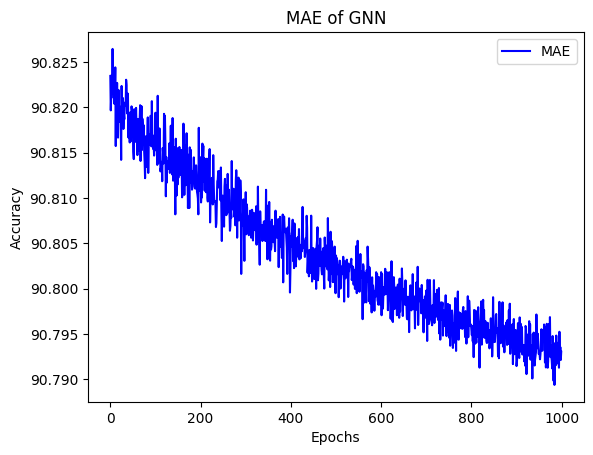

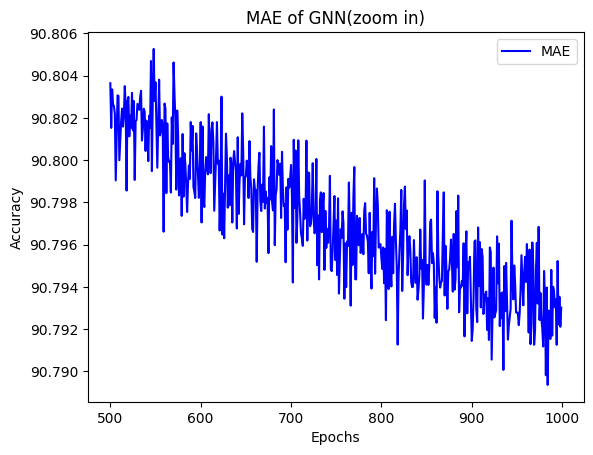

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyQ,"GNN")

##GAT Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c

        self.F = F.softmax

        self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
        self.b = nn.Parameter(torch.Tensor(out_c))

        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features, [B, N, C].
        :param graph: graph structure, [N, N].
        :return:
            output features, [B, N, D].
        """

        h = self.W(inputs)  # [B, N, D]，A linear layer is W*h of the formula in the first step

        # The following is an inner product of the features between the i-th node
        # and the j-th node, indicating the strength of the
        # association between their features.
        # Using graph again means multiplying the adjacency matrix, because the adjacency
         #matrix is ​​represented by 0-1, and 0 means that
        # there is no edge connecting the two nodes.
        # Then the 0 in the final result means that there are no edges connecting the nodes.
        outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  # [B, N, D]*[B, D, N]->[B, N, N],         x(i)^T * x(j)

        # Since 0 in the above calculated results means that there is nothing between the nodes,
        #these 0s are replaced with negative infinity,
        # because the negative infinity of softmax = 0
        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))

        #[B, N, N]，Normalization is performed in the second dimension, which means that
        #all nodes connected by edges are
        #normalized to obtain the attention coefficient
        attention = self.F(outputs, dim=2)

        # [B, N, N] * [B, N, D]，, this is the third step, using the attention coefficient
        #to perform differentiated information aggregation on neighborhood nodes.
        return torch.bmm(attention, h) + self.b


class GATSubNet(nn.Module): # This is the multi-head attention mechanism
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()

        # Use loops to increase multi-attention, and use nn.ModuleList to become a large parallel network
        self.attention_module = nn.ModuleList(
            [GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)])  # in_c is the input feature dimension, hid_c is the hidden layer feature dimension

        # The above multi-head attentions all got different results, and they were
        # aggregated using the attention layer.
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

        self.act = nn.LeakyReLU()


    def forward(self, inputs, graph):
        """
        :param inputs: [B, N, C]
        :param graph: [N, N]
        :return:
        """
        # Each attention head is taken out using a loop, put into a list, and then
         # connected in series in the last dimension.
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
        outputs = self.act(outputs)

        outputs = self.out_att(outputs, graph)

        return self.act(outputs)


class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)

    def forward(self, data, device):
        graph = data["graph"][0].to(device)  # [N, N]
        flow = data["flow_x"]  # [B, N, T, C]
        flow = flow.to(device)  # Send traffic data to the device

        B, N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)  # [B, N, T * C]
        """
       The above is to flatten the feature data of this period of time into features. This
       approach actually ignores the continuity of time series.
       This method is feasible, but it is rough. Of course, you can also do this：
       flow[:, :, 0] ... flow[:, :, T-1]  Then there are T tensors [B, N, C], that is, [B, N, C]*T
       Each tensor is represented by a SubNet, then there are T SubNets in total, initialization definition
       self.subnet = [GATSubNet(...) for _ in range(T)]
       Then use nn.ModuleList to separate the SubNets for processing, refer to the processing of
       multi-head attention, and the same principle

       """
        # [B, N, 1, C], the addition of 1 means that the prediction is a moment in the future
        prediction = self.subnet(flow, graph).unsqueeze(2)

        return prediction


if __name__ == '__main__':  # Test whether the model is suitable
    x = torch.randn(32, 278, 6, 2)  # [B, N, T, C]
    graph = torch.randn(32, 278, 278)  # [N, N]
    data = {"flow_x": x, "graph": graph}

    device = torch.device("cpu")

    model_GAT = GATNet(in_c=6 * 2, hid_c=6, out_c=2, n_heads=2)

    historyO = model_GAT(data, device)
    print(historyO.size())

#Define the metrics and Define the loss function and the
x_input, x_output = gcn_lstm_model.in_out_tensors()
model_GAT = tf.keras.Model(inputs=x_input, outputs=x_output)
optimizer = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
model_GAT.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
historyO = model_GAT.fit(dataset,epochs=epochNum,verbose=0)


torch.Size([32, 278, 1, 2])


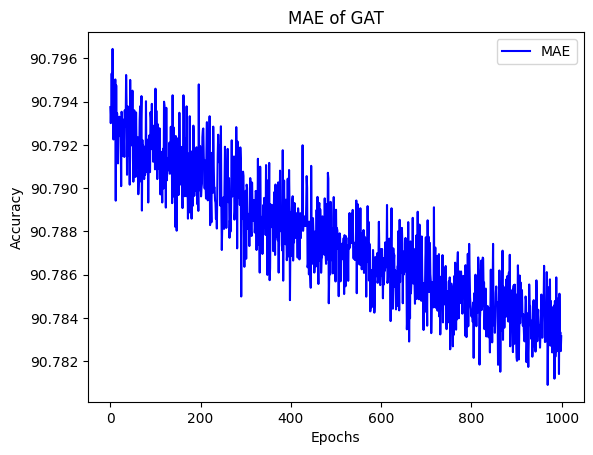

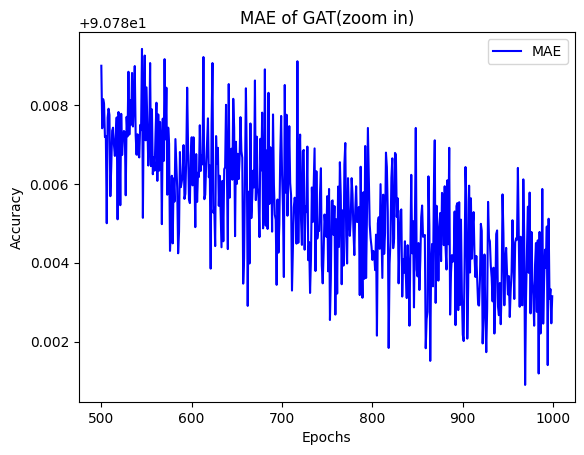

<Figure size 640x480 with 0 Axes>

In [ ]:
plotMAE(historyO, "GAT")

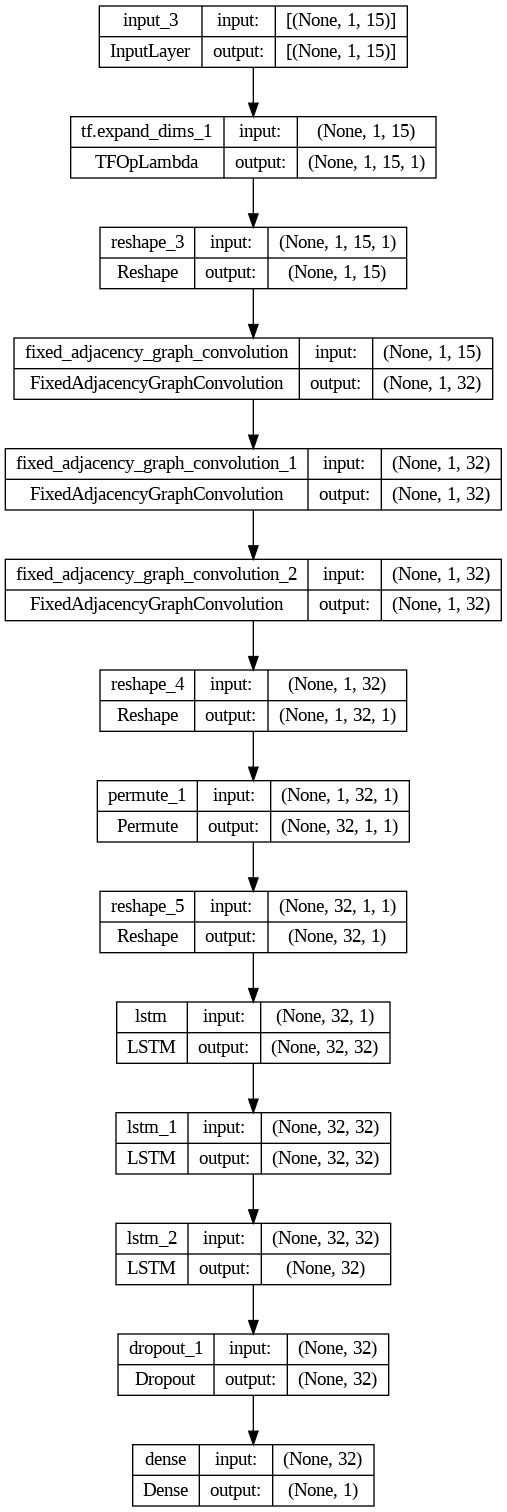

In [ ]:
#Plot the model and save it as an image
plot_model(model_GAT, to_file='mode_GAT.png', show_shapes=True, show_layer_names=True)

In [ ]:
def plotMAE(historys):
  maes = []
  titles =[]
  cols = []
  epochs=range(epochNum) # Get number of epochs
  for his in historys:
    history = his[0]
    titles.append(his[1])
    cols.append(his[2])
    maes.append(history.history['mae'])

  plt.title('MAE Comparision')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")

  for i in range(len(maes)):
    plt.plot(epochs, maes[i], cols[i])

  plt.legend(titles)
  plt.figure()

  zoomstart = int(epochNum/2)
  epochs_zoom = epochs[zoomstart:]

  plt.title('MAE Comparison (zoom in)')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  for i in range(len(maes)):
    plt.plot(epochs_zoom, maes[i][zoomstart:], cols[i])

  plt.legend(titles)
  plt.figure()


  zoomstart = 100
  epochs_zoom = epochs[:zoomstart]

  plt.title('MAE Comparison (zoom in)')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  for i in range(len(maes)):
    plt.plot(epochs_zoom, maes[i][:zoomstart], cols[i])

  plt.legend(titles)
  plt.figure()


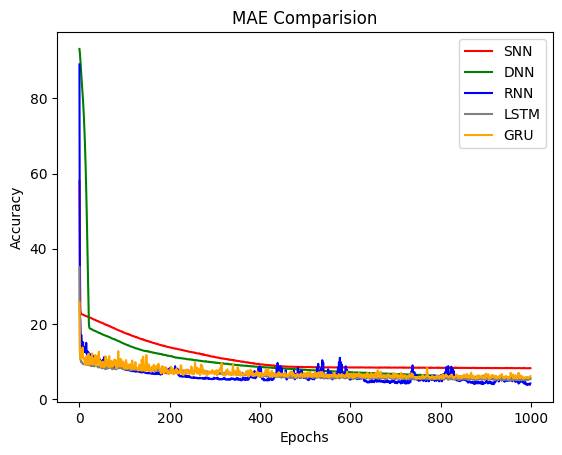

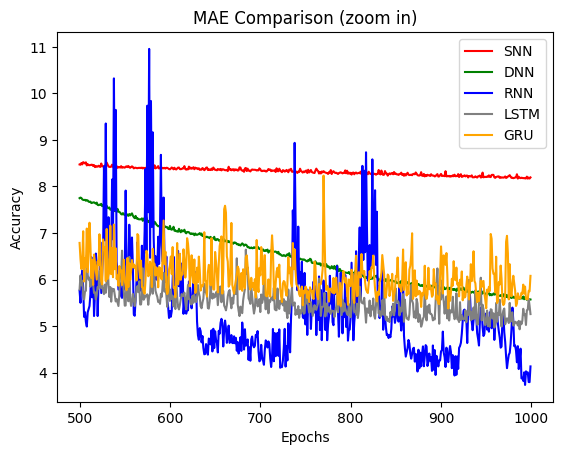

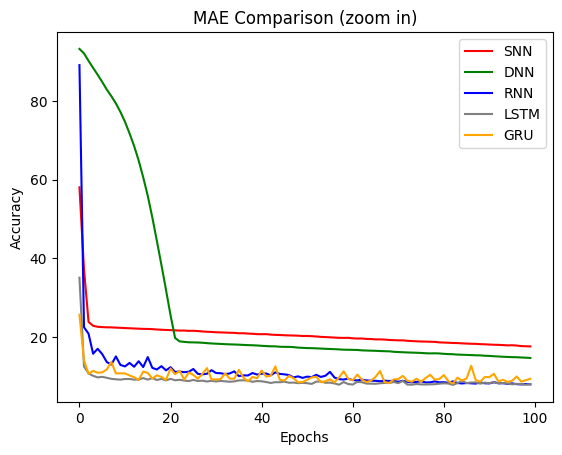

<Figure size 640x480 with 0 Axes>

In [ ]:
histories = [[historyS,"SNN",'red'],[historyD,"DNN",'green'],[historyR,"RNN",'blue'],[historyL,"LSTM",'gray'], [historyM,"GRU",'orange'], ]

plotMAE(histories)

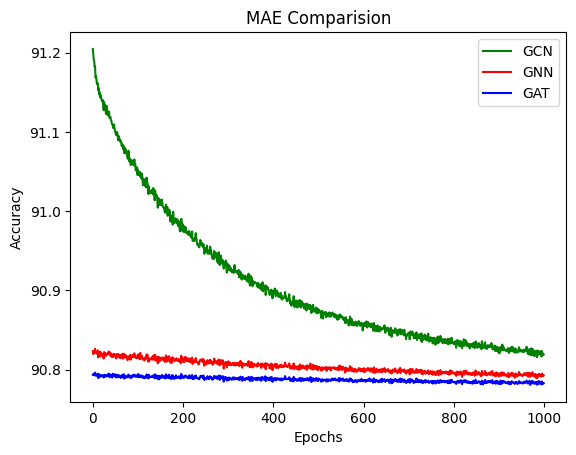

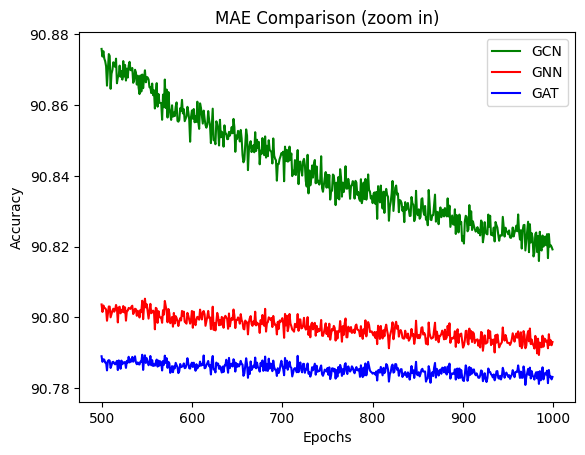

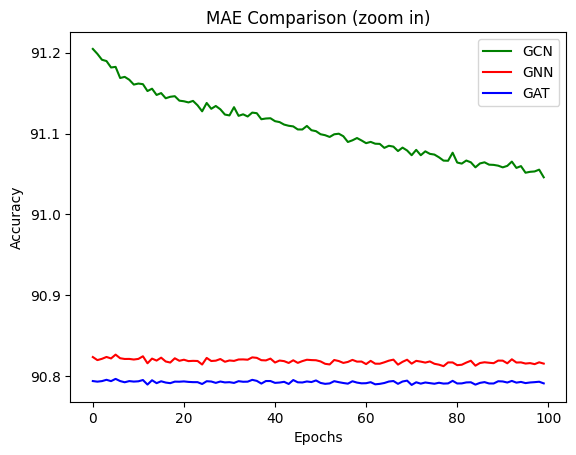

<Figure size 640x480 with 0 Axes>

In [ ]:
histories = [[historyN,"GCN",'green'],[historyQ,"GNN",'red'],[historyO,"GAT",'blue']]

plotMAE(histories)

In [ ]:
print(1 - midv/((maxv+midv)/2))

0.33333333333333337
